# TEST 1: Leveraging LLMs for Feature Generation and Classification

Typically, if our data has $N$ features, we need around $10N$ data items to reach peak performance with classic classifiers like Logistic Regression. Therefore, if our vocabulary has 10,000 words, we would need around 1 million items in the training set to reach peak performance.

An interesting idea regarding this was explored in 2024 in [Balek, V., S'ykora, L., Sklen'ak, V., & Kliegr, T. (2024). LLM-based feature generation from text for interpretable machine learning. ArXiv, abs/2409.07132](https://arxiv.org/abs/2409.07132). The idea is to use an LLM to generate meaningful and interpretable features from text, and then use Logistic Regression for classification.

For example, in the movie plots dataset, we could have features like:
- "Is the protagonist an animal?" (0 or 1)
- "Does the plot indicate psychological suffering?" (0 or 1)

With a reasonable number of these features, our model could make predictions based on meaningful features instead of raw words.

## Objectives
* Perform feature extraction for a particular dataset
* Compare performance and explainability of classifiers with different approaches. 

## Rules

I highlight a few elements of our usual rules:

* You are **NOT ALLOWED** to use AI to generate any code you are asked to make yourself. This includes ChatGPT, CoPilot and all similar generators.
* You are **NOT ALLOWED** to use Google or any other search engine.
* You are **ALLOWED** to use the offical documentations for libraries: 
    * [sklearn](https://scikit-learn.org/)
    * [numpy](https://numpy.org/)
    * [matplotlib](https://matplotlib.org/)
    * [google AI studio](https://aistudio.google.com/)
* You are **ALLOWED** to use previous code from this course as basis.
* You **MUST** use the university's proctoring software to show you are complying with these rules
* This task is **INDIVIDUAL**. DO NOT share your code or results with anyone else.

## Tasks and Deliverables

* At any point, refer to [Balek et al.](https://arxiv.org/abs/2409.07132). 
* Make a well-commented code to solve each one of the tasks below.
* Each task will be evaluated as:
    * Insufficient: task is not done, off-topic, or low-effort
    * In process: task is incomplete, done with a clear conceptual error, or comments 
    * Proficient: everything works and comments are enough to understand what is being done
    * Advanced: everything works, comments are enough to understand what is being done, and code is well organized and formated using functions, dataclasses, and other adequate structures.
* This task should be finished by the end of the class.
* After you are finished, submit the executed notebook in our LMS system.

### 1. Dataset Preparation:
Adapting Balek et al.'s strategy to our movie plot classification case, create a dataset with at least 100 labeled items and at least 5 meaningful features. None of the features can be the class itself ("is this a drama plot?"). Use a clear strategy to avoid exceeding free tier quotas. Store data locally in a format of your choice.

### 2. Classification:
Use the generated features to train a Logistic Regression model. Use cross-validation to select the best hyperparameters. Report accuracy and f1-score for your classifier.

### 3. Performance Comparison
Compare the performance of the following approaches:
1. Traditional Bag-of-Words
2. LLM-generated features with Logistic Regression
3. Direct classification using LLM

Use a bar plot to show the performance differences (choose either accuracy or F1-score).

### 4. Improvement Strategies
Determine whether labeling more items would improve system performance. Use data to justify your answer.


In [166]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/tiagoft/NLP/main/wiki_movie_plots_drama_comedy.csv')
df.head()

,Plot,Genre
0,The film is about a family who move to the sub...,comedy
1,Before heading out to a baseball game at a nea...,comedy
2,The plot is that of a black woman going to the...,comedy
3,On a beautiful summer day a father and mother ...,drama
4,A thug accosts a girl as she leaves her workpl...,drama


### Bag of Words

In [167]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


x_train, x_test, y_train, y_test = train_test_split(df['Plot'], df['Genre'], test_size=0.2)

vect = CountVectorizer(binary=True, stop_words='english')
X_train_matrix = vect.fit_transform(x_train)
X_test_matrix = vect.transform(x_test)

print(f"O conjunto de treino possui {X_train_matrix.shape[0]} textos e {X_train_matrix.shape[1]} colunas (palavras únicas)")
print(f"O conjunto de teste possui {X_test_matrix.shape[0]} textos e {X_test_matrix.shape[1]} colunas (palavras únicas)")

O conjunto de treino possui 8274 textos e 62379 colunas (palavras únicas)
O conjunto de teste possui 2069 textos e 62379 colunas (palavras únicas)


In [168]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

model = BernoulliNB()
model.fit(X_train_matrix, y_train)
y_pred = model.predict(X_test_matrix)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

Accuracy:  0.7327211213146447


In [169]:
from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score

recall_bag = recall_score(y_test, y_pred, average='macro')
precision_bag = precision_score(y_test, y_pred, average='macro')
f1_score_bag = f1_score(y_test, y_pred, average='macro')
balanced_accuracy_score_bag = balanced_accuracy_score(y_test, y_pred)

print(f'Recall: {recall_bag:.2f}')
print(f'Precision: {precision_bag:.2f}')
print(f'F1: {f1_score_bag:.2f}')
print(f'Balanced accuracy: {balanced_accuracy_score_bag:.2f}')

Recall: 0.71
Precision: 0.74
F1: 0.71
Balanced accuracy: 0.71


[[0.54362416 0.45637584]
 [0.12340426 0.87659574]]


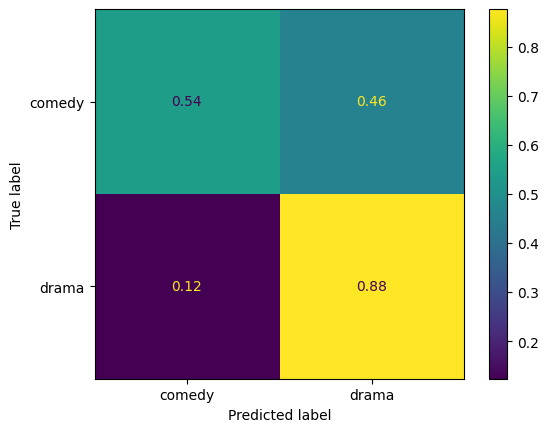

In [170]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

c = confusion_matrix(y_test, y_pred, normalize='true')
print(c)
_ = ConfusionMatrixDisplay(c, display_labels=['comedy', 'drama']).plot()


### LLM-generated features with Logistic Regression

In [171]:
import os
import dotenv
import google.generativeai as genai
import json
import time

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

# Start the use of the API
genai.configure(api_key=GEMINI_API_KEY)

df_ = df.sample(100)

i = 0
current_responses = []
while i < len(df_):
    plot = df_.iloc[i]['Plot']

    prompt = f"""You will help me by analysing a movie plot. I will ask you some questions and you will answer either 1 (for yes) or 0 (for no). 
    In case you are in doubt, make your best guess.
    Also, identify if the plot genre is COMEDY or DRAMA.
    Answer the questions as a JSON file, in the format:

    {{
    "Q1" : "Answer to Q1",
    "Q2" : "Answer to Q2",
    "Q3" : "Answer to Q3",
    "Q4" : "Answer to Q4",
    "Q5" : "Answer to Q5",
    "LLM_Genre" : "DRAMA" or "COMEDY"
    }}

    The questions are:

    Q1: Is the protagonist an animal?
    Q2: Can that movie make me rethink my life choices?
    Q3: Am I going to cry when I watch the movie?
    Q4: Is the plot absurd or exaggerated?
    Q5: Could the situations in the movie realistic happen to an average person?
    
    The movie plot is: {plot}
    """

    generation_config = genai.GenerationConfig(
    max_output_tokens=100,
    temperature=0.0,
    response_mime_type='application/json'
    )

    model = genai.GenerativeModel(model_name="gemini-2.0-flash")

    try:
        response = model.generate_content(prompt,
                                        generation_config=generation_config)
        
        i += 1
        print(i)
    except:
        print("Wait...")
        time.sleep(10)

    response_dict = json.loads(response.text)
    current_responses.append(response_dict)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
Wait...
16
17
Wait...
Wait...
18
19
Wait...
20
Wait...
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
Wait...
39
40
41
42
Wait...
Wait...
Wait...
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
Wait...
Wait...
62
Wait...
63
Wait...
Wait...
64
65
66
67
68
69
70
71
72
73
74
75
76
77
Wait...
Wait...
78
79
80
81
82
Wait...
83
Wait...
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Wait...
100


In [172]:
current_responses_df = pd.DataFrame(current_responses)
current_responses_df

,Q1,Q2,Q3,Q4,Q5,LLM_Genre
0,0,0,0,1,1,COMEDY
1,0,1,1,0,1,DRAMA
2,0,0,0,1,0,COMEDY
3,0,1,1,0,1,DRAMA
4,0,0,0,1,1,COMEDY
...,...,...,...,...,...,...
114,0,0,0,1,0,COMEDY
115,0,1,1,0,1,DRAMA
116,0,0,0,0,1,COMEDY
117,0,0,0,0,1,COMEDY


In [173]:
df_ = df_.iloc[0:100]
current_responses_df = current_responses_df.iloc[0:100]

df_['Q1'] = list(current_responses_df['Q1'].astype(int))
df_['Q2'] = list(current_responses_df['Q2'].astype(int))
df_['Q3'] = list(current_responses_df['Q3'].astype(int))
df_['Q4'] = list(current_responses_df['Q4'].astype(int))
df_['Q5'] = list(current_responses_df['Q5'].astype(int))
df_['LLM_Genre'] = list(current_responses_df['LLM_Genre'])

df_.head()



,Plot,Genre,Q1,Q2,Q3,Q4,Q5,LLM_Genre
8679,Tim (Michael Hui) and Lee (Samuel Hui) are emp...,comedy,0,0,0,1,1,COMEDY
4591,Scorchers takes place in cajun Louisiana on th...,drama,0,1,1,0,1,DRAMA
4936,A crafty nightclub owner (Jack) brings togethe...,drama,0,0,0,1,0,COMEDY
10158,Film is set in a small village of Ina district...,drama,0,1,1,0,1,DRAMA
1381,Amalgamated Pictures is seeking new stars for ...,drama,0,0,0,1,1,COMEDY


In [174]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    "penalty":[None, "l2"],
    "fit_intercept":[True, False],
    "class_weight":[None, 'balanced']
}

x_train, x_test, y_train, y_test = train_test_split(df_[['Q1','Q2','Q3','Q4','Q5']], df_['Genre'], test_size=0.2)


grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

grid.fit(x_train, y_train)
print(f'Best parameters: {grid.best_params_}')
print(f'Best cross-validation accuracy: {grid.best_score_:.2f}')

Best parameters: {'class_weight': None, 'fit_intercept': False, 'penalty': 'l2'}
Best cross-validation accuracy: 0.49


In [175]:
import numpy as np

accuracies = []
for _ in range(50):
    x_train, x_test, y_train, y_test = train_test_split(df_[['Q1','Q2','Q3','Q4','Q5']], df_['Genre'], test_size=0.2)
    model = LogisticRegression(random_state=42, fit_intercept=True, penalty=None, class_weight='balanced')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

print(np.mean(accuracies))

0.493


In [176]:
recall_log = recall_score(y_test, y_pred, average='macro')
precision_log = precision_score(y_test, y_pred, average='macro')
f1_score_log = f1_score(y_test, y_pred, average='macro')
balanced_accuracy_score_log = balanced_accuracy_score(y_test, y_pred)

print(f'Recall: {recall_log:.2f}')
print(f'Precision: {precision_log:.2f}')
print(f'F1: {f1_score_log:.2f}')
print(f'Balanced accuracy: {balanced_accuracy_score_log:.2f}')

Recall: 0.65
Precision: 0.72
F1: 0.64
Balanced accuracy: 0.65


[[0.91666667 0.08333333]
 [0.625      0.375     ]]


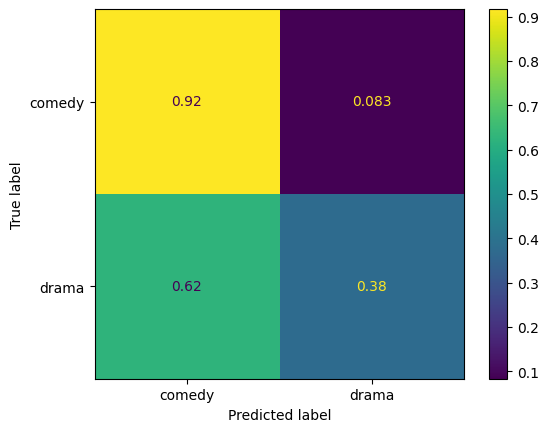

In [177]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

c = confusion_matrix(y_test, y_pred, normalize='true')
print(c)
_ = ConfusionMatrixDisplay(c, display_labels=['comedy', 'drama']).plot()

### Direct classification

In [178]:
print(accuracy_score(df_['Genre'].str.upper(), df_['LLM_Genre'].str.upper()))

0.49


### Plot

Text(0.5, 1.0, 'Balanced Score Scores Comparison')

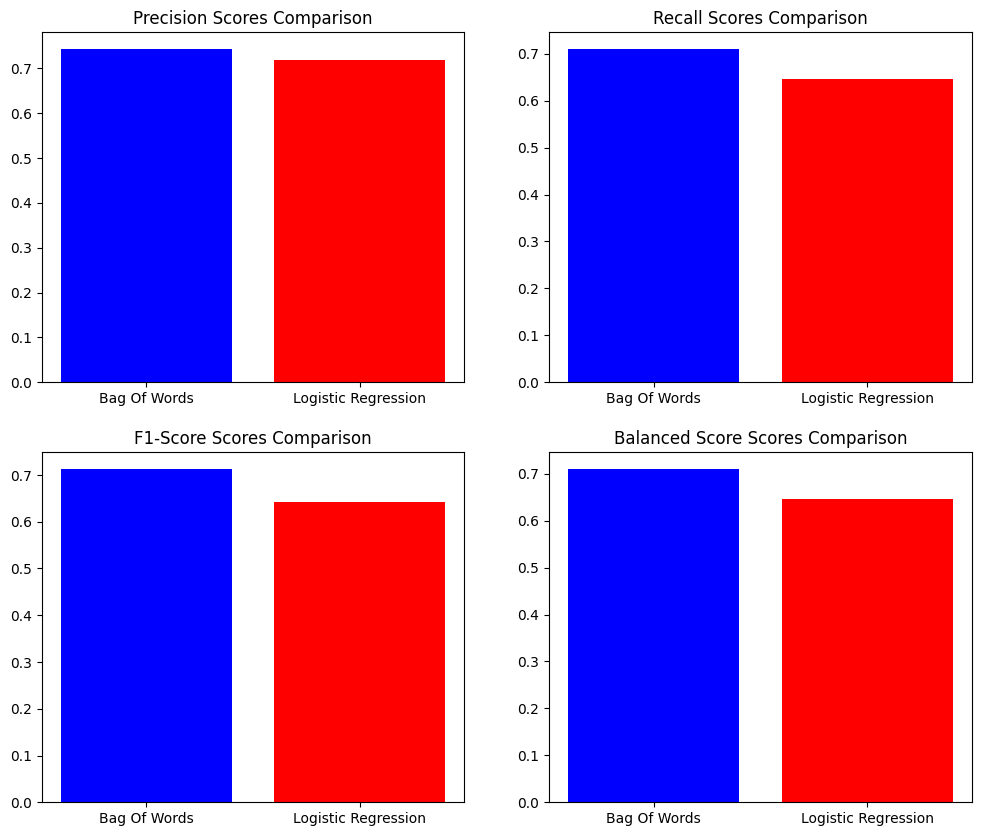

In [179]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0,0].bar(['Bag Of Words', 'Logistic Regression'], [precision_bag, precision_log], color=['blue','red'])
axes[0,0].set_title('Precision Scores Comparison')

axes[0,1].bar(['Bag Of Words', 'Logistic Regression'], [recall_bag, recall_log], color=['blue','red'])
axes[0,1].set_title('Recall Scores Comparison')

axes[1,0].bar(['Bag Of Words', 'Logistic Regression'], [f1_score_bag, f1_score_log], color=['blue','red'])
axes[1,0].set_title('F1-Score Scores Comparison')

axes[1,1].bar(['Bag Of Words', 'Logistic Regression'], [balanced_accuracy_score_bag, balanced_accuracy_score_log], color=['blue','red'])
axes[1,1].set_title('Balanced Score Scores Comparison')

In [180]:
df_['Genre'].value_counts()

Genre
drama     56
comedy    44
Name: count, dtype: int64

### Testando outras abordagens

In [209]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


x_train, x_test, y_train, y_test = train_test_split(df_[['Q1','Q2','Q3','Q4','Q5']], df_['Genre'], random_state=42)


param_grid = {
    'n_estimators': [1, 10, 50, 100, 200],
    'max_depth':[None, 1, 3, 5, 10],
    'class_weight':[None, 'balanced']
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)


grid.fit(x_train, y_train)
print(f'Best parameters: {grid.best_params_}')
print(f'Best cross-validation accuracy: {grid.best_score_:.2f}')

Best parameters: {'class_weight': None, 'max_depth': None, 'n_estimators': 1}
Best cross-validation accuracy: 0.61


In [222]:
from sklearn.pipeline import Pipeline

accuracies = []
for _ in range(50):
    x_train, x_test, y_train, y_test = train_test_split(df_[['Q1','Q2','Q3','Q4','Q5']], df_['Genre'])

    model = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=1, class_weight=None)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

print(np.mean(accuracies))

0.5064


In [223]:
print(y_train.value_counts())

Genre
drama     40
comedy    35
Name: count, dtype: int64


[[0.22222222 0.77777778]
 [0.4375     0.5625    ]]


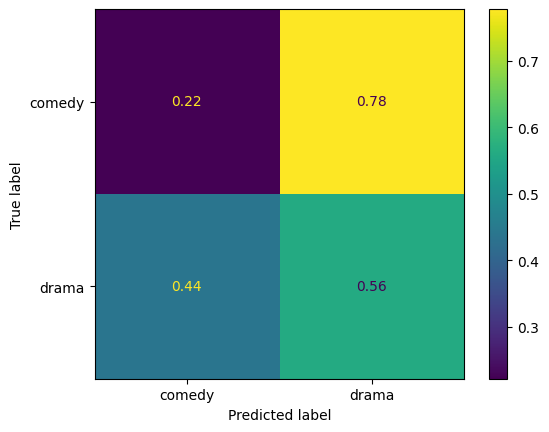

In [224]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

c = confusion_matrix(y_test, y_pred, normalize='true')
print(c)
_ = ConfusionMatrixDisplay(c, display_labels=['comedy', 'drama']).plot()